<center><h1>VC02: K-means</h1></center>

En esta práctica estudiaremos el funcionamiento y la utilización del popular algoritmo de clustering K-means.

Para empezar, cargamos las librerías que vamos a necesitar:

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


Cargamos el dataset con el que vamos a trabajar:


El dataset cargado tiene 1999 instancias.


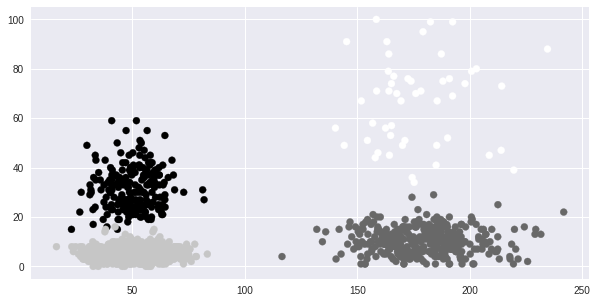

In [2]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)


El algoritmo K-means tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en elegir unos centros iniciales.


Los centros iniciales elegidos aleatoriamente son:
[[220.80494418  30.2127365 ]
 [ 47.59924816  44.20663245]
 [ 41.49256846  31.02474709]]


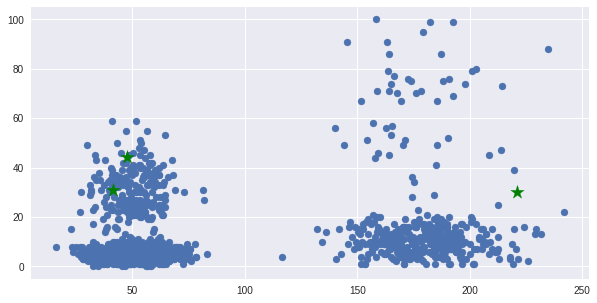

In [3]:
# Elegimos un número de clústeres a buscar
K = 3

cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')


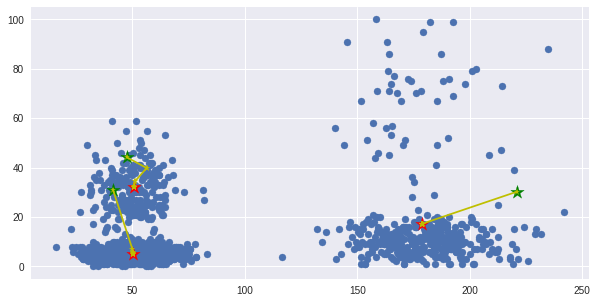

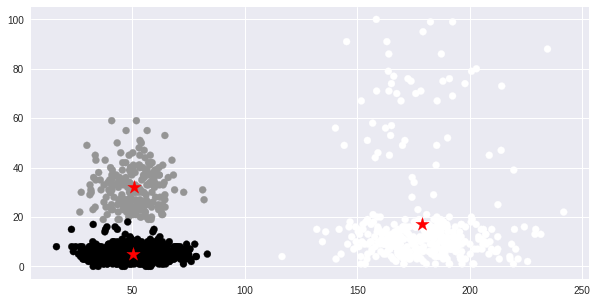

In [4]:
# Definimos la distancia euclidiana de una instancia x 
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')

# Flag de convergencia
iterando = True

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i], cDx)) 
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        cDx[k,:] = ([np.mean(Dx[Dyp == k][:,0]), np.mean(Dx[Dyp == k][:,1])]) 
        
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]], linestyle='-', marker='*', c='y')
    
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')


In [5]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/np.sum(mat[l,:]) 

def medida_recall(mat, l, k):
    return mat[l,k]/np.sum(mat[:,k]) 

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] 
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return (2 * prec * rec) / (prec + rec) 

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC), ' (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)')
print('El valor F1 es = ', medida_f1(mC))

[[  49    0    0]
 [   0    0 1393]
 [ 346    0    0]
 [   0  206    5]]
El valor del error cometido es =  0.002501250625312701
La pureza del agrupamiento obtenido es =  0.9729864932466232  (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)
El valor F1 es =  0.966938432186003


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo K-means. 

Centros encontrados por...
el método programado
el método de Sci-kit Learn
[[ 50.31548005   8.65710723]
 [178.88448101  17.31898734]]
Matriz de confusión:
[[   0   49]
 [1393    0]
 [   0  346]
 [ 211    0]]
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.869934967483742
El valor F1 es =  0.8393806756910955


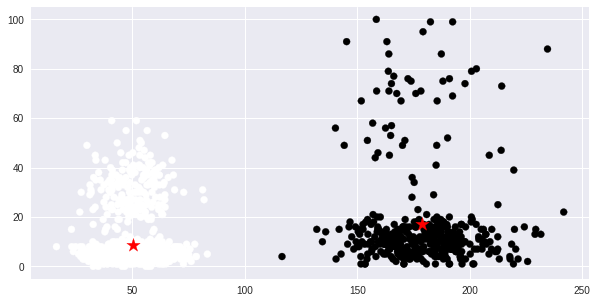

In [6]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=2)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print("Centros encontrados por...")
print("el método programado")
#print(cDx)
print("el método de Sci-kit Learn")
print(cDx_sk)


mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


<hr>
<h2>K-mediods</h2>

Hay ocasiones en que los centros no se pueden calcular. Esto pasa habitualmente cuando los datos son heterogeneos (una mezcla de variables continuas y categóricas). El algoritmo se plantea de manera equivalente a K-means, pero la selección de centros se realiza sobre el conjunto de datos de entrenamiento. Sólo con el objetivo de poder visualizar los resultados, usaremos un conjunto de datos continuo:


El dataset cargado tiene 767 instancias.


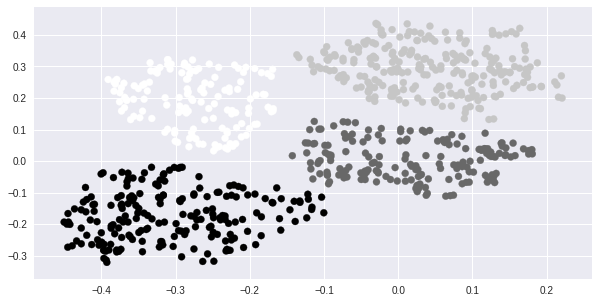

In [7]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_separables_peque.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

Los centros iniciales elegidos aleatoriamente son:
[[-0.355802   0.238831 ]
 [-0.0857934  0.33742  ]
 [-0.123291   0.026156 ]]


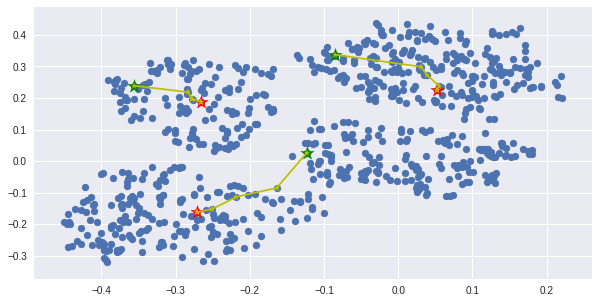

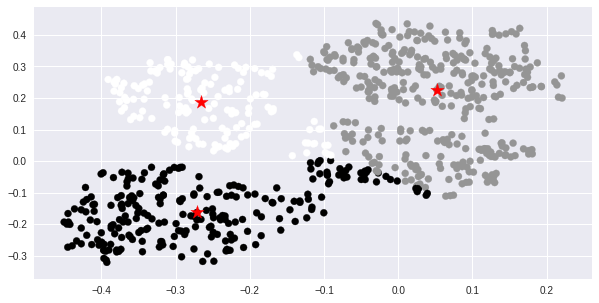

In [8]:
# Elegimos un número de clústeres a buscar
K = 3

# Elegimos los centros iniciales entre el conjunto de datos
cDx = Dx[np.random.choice(Dx.shape[0], K, replace=False),:]

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')

# Definimos la distancia euclidiana de una instancia x 
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

# Flag de convergencia
iterando = True

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i], cDx)) 
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        mat = matriz_distancias(Dx[Dyp==k,:],distancia_euclidiana)
        ic = np.where(Dyp==k)[0][np.argmin(np.sum(mat, axis=1))]
        cDx[k,:] = Dx[ic,:]

    # Se muestra el desplazamiento de los centroides
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]], linestyle='-', marker='*', c='y')
    
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

# Se muestran los centroides finales
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')


<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


Text(0, 0.5, 'Medida de R cuadrado')

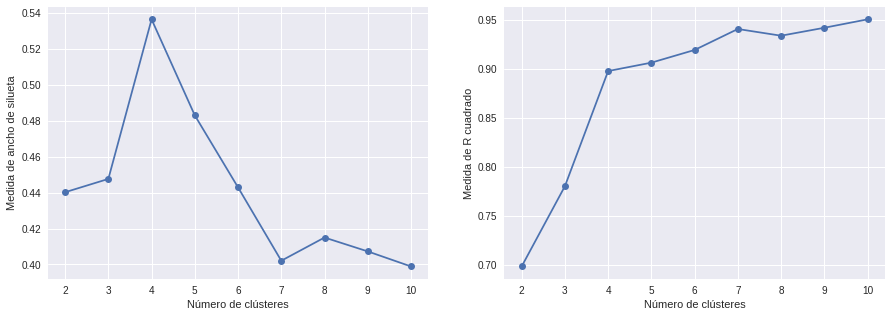

In [9]:
from sklearn.metrics import silhouette_score

def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return (sumTotal - interior) / sumTotal 
    
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k)
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rrsquare[k-2]  = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")


Se observa que el punto con mayor puntuación es el K=4 en el caso de ancho de silueta. Con esto, podría ser suficiente. Sin embargo, si nos fijamos en la medida R cuadrado, se observa un marcado cambio de tendencia también en K=4. Este cambio es conocido como el codo. La práctica recomendada de este procedimiento indica que se debe seleccionar el punto donde se produzca el cambio de tendencia (el codo). 

Así, no cabe duda de que el mejor valor de K posible es 4, de acuerdo a ambas medidas.


<hr>
<h2>Crea tus propios datasets de ejemplo</h2>

Python implementa la función make_blobs, que permite generar conjuntos de datos de manera sencilla especificando simplemente el número de ejemplos (n_samples), el número de dimensiones (n_features) y el número de clústeres (centers):


Text(0.5, 0.92, 'Clústeres y asignaciones predichos')

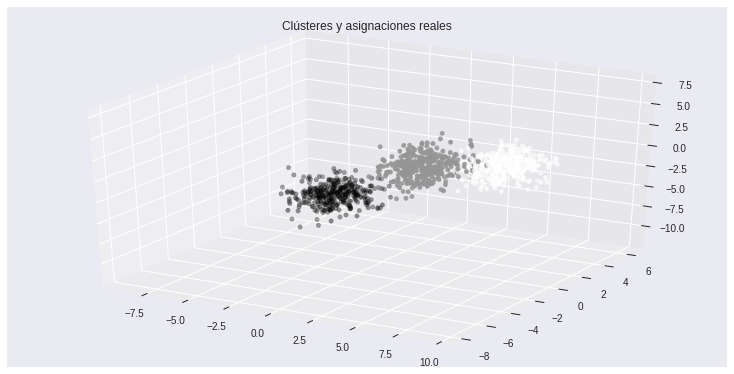

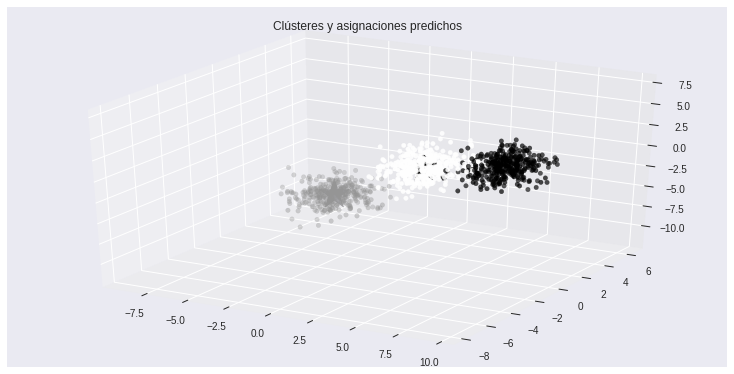

In [10]:
# Creamos un dataset con 3 dimensiones y 4 clústeres
Dx, Dy = make_blobs(n_samples=1000, n_features=3, centers=3)

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 2], c=Dy)
ax.set_title("Clústeres y asignaciones reales")

modelo = KMeans(n_clusters=3)
modelo = modelo.fit(Dx)
Dyp_sk = modelo.predict(Dx)
cDx_sk = modelo.cluster_centers_

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 2], c=Dyp_sk)
ax.scatter(cDx_sk[:, 0], cDx_sk[:, 1], cDx_sk[:, 2], marker='*', c='#050505', s=1000)
ax.set_title("Clústeres y asignaciones predichos")